In [1]:
from pyonset import Onset, BootstrapWindow, OnsetStatsArray

In [2]:
# First we have the data in a pandas dataframe, indexed by time and preferably the index knows the frequency
# We need to tell the software the particle species and all of the channel energy boundaries
# The software has to differentiate between custom data and default data when running processes (self.custom_data)
import os
import pandas as pd

In [3]:
# The path to the data archive
example_data_path = "/home/chospa/bepicolombo/bepi_sixsp_plotter/2023-03-13/data"

# The name of the file to read in
filename = "phys_data_2023-03-12_side0.csv"

# Reading the file to a dataframe
df = pd.read_csv(f"{example_data_path}{os.sep}{filename}", index_col="TimeUTC")

# The index of the dataframe needs to be datetime, and the frequency of it must be known
df.index = pd.to_datetime(df.index)
df.index.freq = "24 s"

# No unnecessary data columns
df.drop(columns=["DT", "PA"], inplace=True)

# Drop also proton columns
df.drop(columns=[f"P{i}" for i in range(1,10)], inplace=True)

# Displays the dataframe
display(df)

,E1,E2,E3,E4,E5,E6,E7
TimeUTC,,,,,,,
2023-03-12 00:00:00,0.0,0.0,11.40,0.0,0.0,0.000,0.000
2023-03-12 00:00:24,167.0,0.0,7.58,0.0,0.0,0.000,0.000
2023-03-12 00:00:48,0.0,0.0,0.00,0.0,0.0,0.627,0.000
2023-03-12 00:01:12,112.0,17.6,0.00,0.0,0.0,0.313,0.000
2023-03-12 00:01:36,55.8,0.0,0.00,0.0,0.0,0.000,0.000
...,...,...,...,...,...,...,...
2023-03-14 23:58:00,7090.0,2200.0,865.00,325.0,10.5,0.314,0.000
2023-03-14 23:58:24,5030.0,1920.0,819.00,309.0,21.0,0.000,0.088
2023-03-14 23:58:48,6480.0,2360.0,895.00,262.0,16.8,0.314,0.000


In [4]:
electrons = Onset(spacecraft="Bepicolombo", sensor="SIXS-P", species="electron", data_level="l2", data_path=example_data_path,
                 start_date="2023-03-12", end_date="2023-03-14",
                 data=df)

Utilizing user-input data. Some SEPpy functionality may not work as intended.


In [19]:
# In case of custom data, the software needs to be explicitly told what are the boundaries of the energy channels

sixs_e_lows = [55, 78, 134, 235, 1000, 1432, 4904]
sixs_e_highs = [92, 143, 214, 331, 1193, 3165, 10000]

sixs_p_lows = [0.801, 1.088, 1.407, 2.139, 3.647, 7.533, 13.211, 22.606, 29.246]
sixs_p_highs = [1.254, 1.311, 1.608, 2.388, 4.241, 8.534, 15.515, 28.413, 40.]

electrons.set_custom_channel_energies(low_bounds=sixs_e_lows, high_bounds=sixs_e_highs, unit="keV")
#protons.set_custom_channel_energies(low_bounds=sixs_p_lows, high_bounds=sixs_p_highs, unit="MeV")

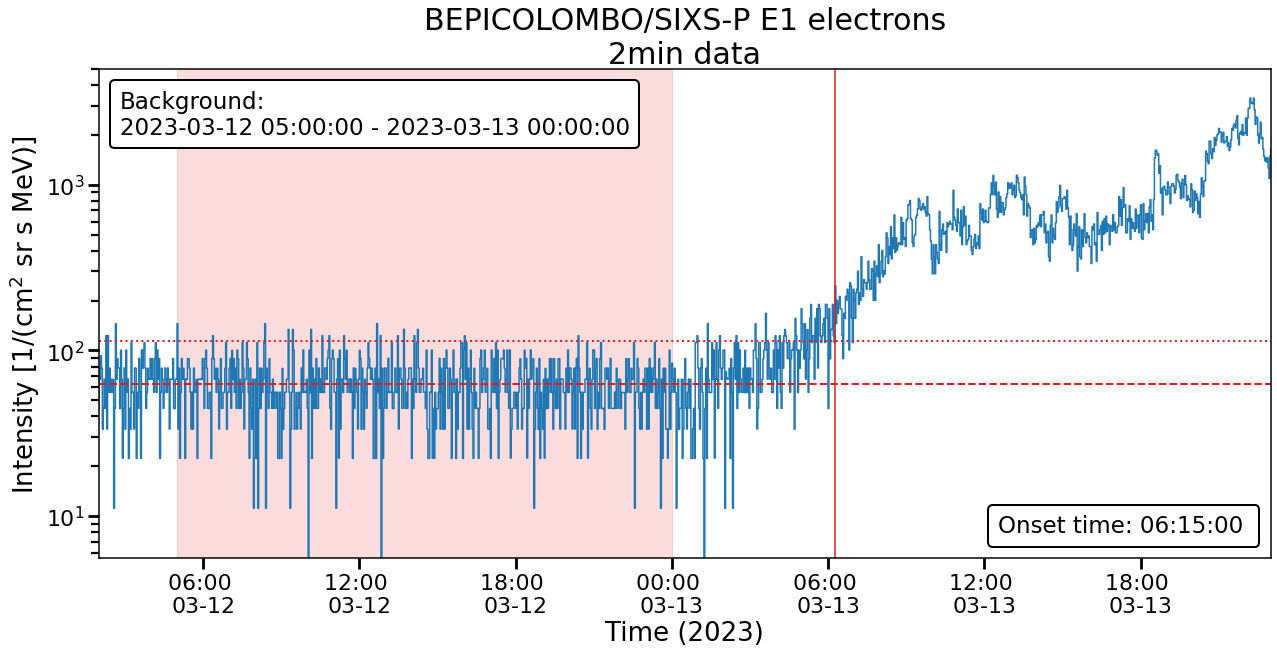

In [16]:
channel = "E1"
plot_range = ["2023-03-12 02:00", "2023-03-13 23:00"]
background = BootstrapWindow(start="2023-03-12 05:00", end="2023-03-13 00:00", bootstraps=1000)
resample = "2 min"
cusum_minutes = 60
#
onset_stats, flux_series = electrons.cusum_onset(channels=channel, background_range=background, xlim=plot_range, ylim=None,
                                             resample=resample, cusum_minutes=cusum_minutes, savepath="plots/onsets", save=False)

In [18]:
sample_size = 0.75
limit_averaging = "11 min"

uncertainty_stats_by_channel = electrons.onset_statistics_per_channel(channels=list(electrons.data.columns), background=background, 
                                                                      cusum_minutes=cusum_minutes,
                                                                      sample_size=sample_size, viewing=electrons.viewing, 
                                                                      limit_computation_time=True,
                                                                      print_output=True, limit_averaging=limit_averaging)

Your chosen background is 1140 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 11 minutes or enlarge the background window.
Channel E1:
~68 % uncertainty for the self time with native data resolution: 0 days 00:26:00
Averaging up to 11 minutes
Channel E2:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Channel E3:
~68 % uncertainty for the self time with native data resolution: 0 days 00:09:00
Averaging up to 9 minutes
Channel E4:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Channel E5:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Channel E6:
~68 % uncertainty for the self time with native data resolution: 0 days 00:27:00
Averaging up to 11 minutes
Channel E7:
 function unique_vals() output: NaT, [1000]
~68 % uncertainty for the self time with native data resolution: NaT
 function unique_vals() output: 

In [ ]:
electrons.VDA()

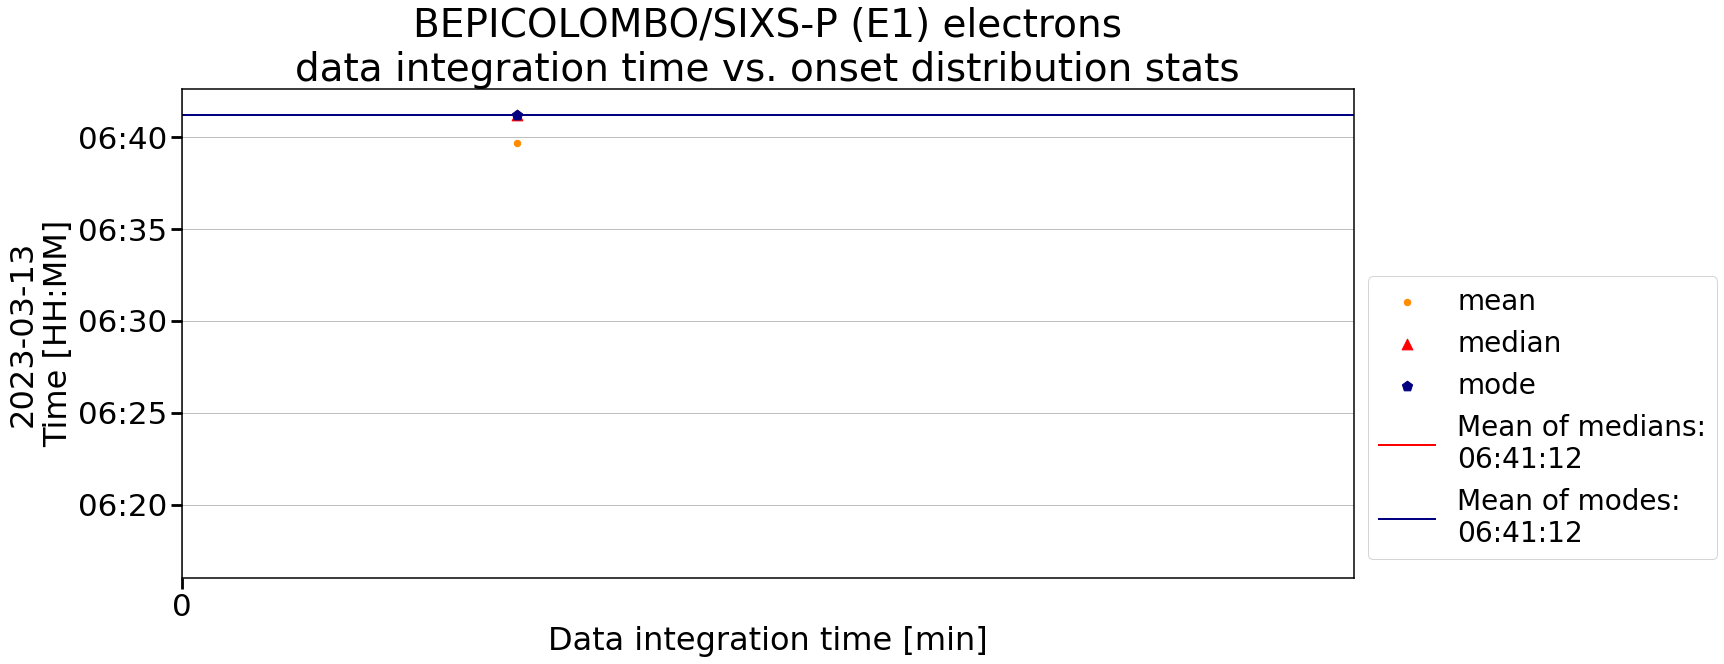

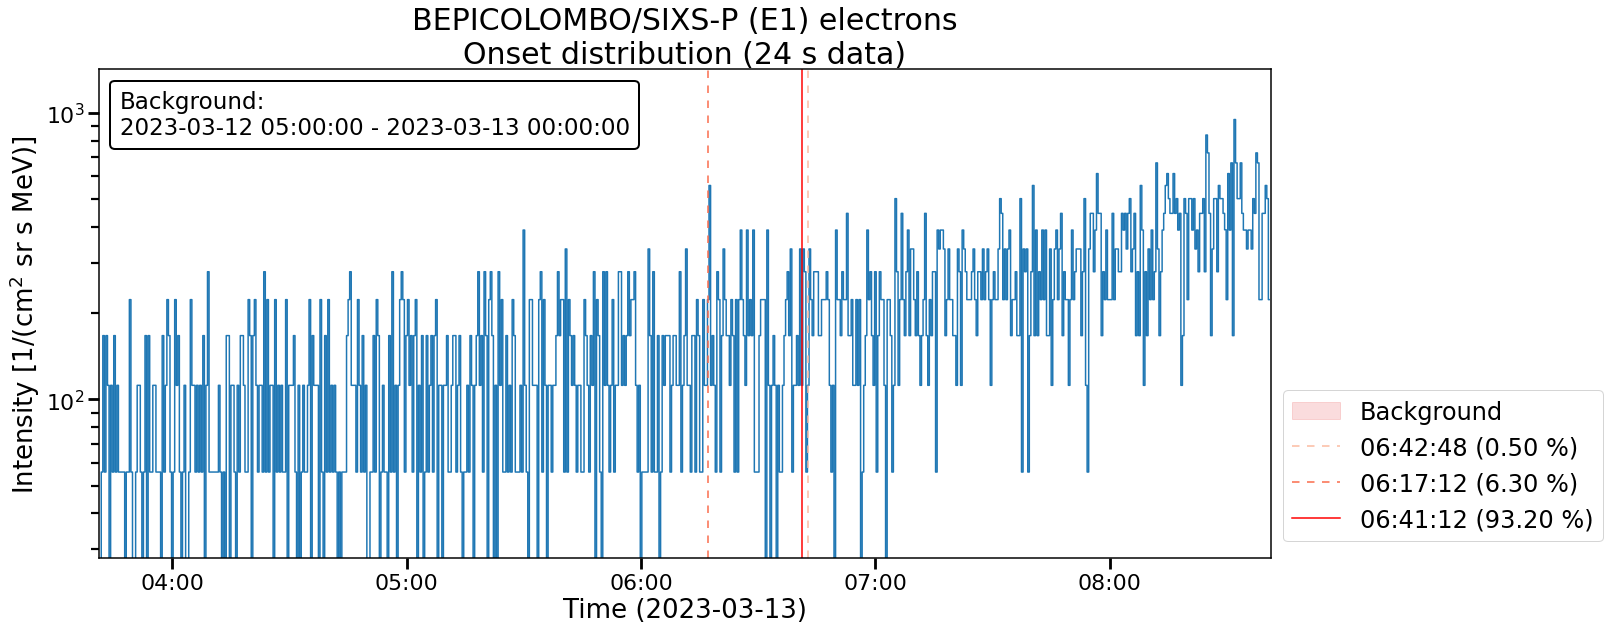

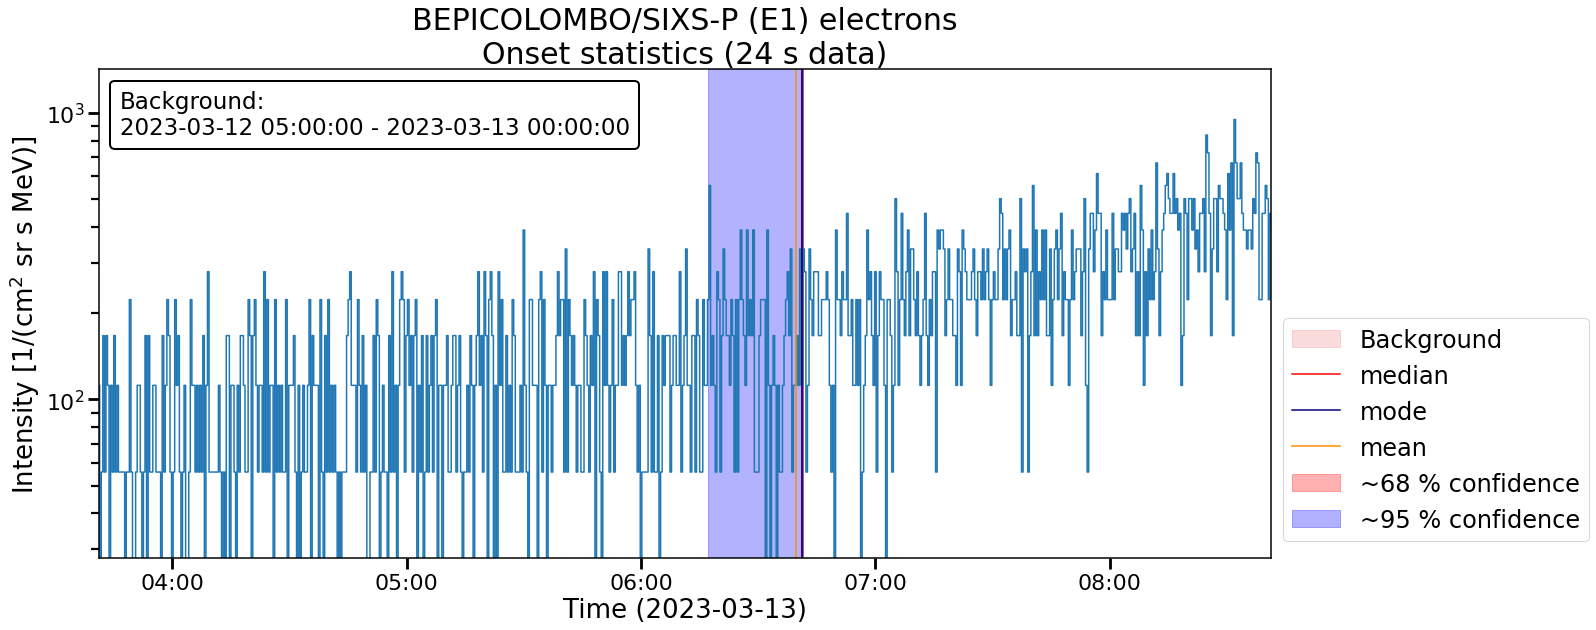

In [35]:
uncertainty_stats_by_channel[0].integration_time_plot()
uncertainty_stats_by_channel[0].show_onset_distribution()
uncertainty_stats_by_channel[0].show_onset_statistics()

In [36]:
electrons.VDA()

UnboundLocalError: local variable 'energy_ranges' referenced before assignment

In [37]:
def input_channel_energies(self, low_bounds, high_bounds):
    """
    For user-input data: explicitly tell the program which energy bounds to use. 
    """
    
    # Check that the amount of bounds is the same as the amount of channels
    if len(low_bounds) != len(self.data.columns) or len(high_bounds) != len(self.data.columns):
        raise IndexError("Length of low bounds or high bounds doesn't equal the amount of channels!")
    
    # Create a class attribute of these
    self.channel_energies = [low_bounds, high_bounds]